In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [40]:
def load_all_data():
    # Paths
    DATA_PATH = "/content/drive/MyDrive/Classes/CLASSES 25-26/FALL '25/ORF 498/ORF498_Final_Report/processed_covid_state_data.csv"
    ADJ_PATH = "/content/drive/MyDrive/Classes/CLASSES 25-26/FALL '25/ORF 498/ORF498_Final_Report/state_adjacency.json"

    # Load COVID + population data
    df = pd.read_csv(DATA_PATH, parse_dates=["date"])

    # Aggregate daily new cases by state
    daily_cases = (
        df.groupby(["date", "state"])["new_cases_7day"]
          .sum()
          .unstack("state")
          .fillna(0)
    )

    # Extract population (state-indexed)
    pop = (
        df[["state", "pop_2020"]]
        .drop_duplicates()
        .set_index("state")["pop_2020"]
    )

    # Load adjacency
    with open(ADJ_PATH, "r") as f:
        adjacency = json.load(f)

    return daily_cases, pop, adjacency

In [41]:
'''
Build a row-stochastic spatial mixing matrix that distributes infection
pressure across each state and its neighboring states
'''
def build_weight_matrix(states, adjacency, self_weight=0.7):
    n = len(states)
    W = np.zeros((n, n))
    idx = {s: i for i, s in enumerate(states)}

    for s in states:
        i = idx[s]
        neighbors = [n for n in adjacency.get(s, []) if n in idx]

        if len(neighbors) == 0:
            W[i, i] = 1.0
        else:
            W[i, i] = self_weight
            w = (1.0 - self_weight) / len(neighbors)
            for nb in neighbors:
                W[i, idx[nb]] = w

    return W, idx

In [42]:
'''
Advance one time step of a network-coupled SIRS model with transmission,
recovery, and waning immunity
'''
def step_sirs(S, I, R, W, beta, gamma, xi, dt=1.0):
    N = np.maximum(S + I + R, 1.0)

    force = W @ (I / N)

    new_inf = beta * S * force * dt
    recov = gamma * I * dt
    loss_imm = xi * R * dt

    S_next = np.maximum(S - new_inf + loss_imm, 0)
    I_next = np.maximum(I + new_inf - recov, 0)
    R_next = np.maximum(R + recov - loss_imm, 0)

    return S_next, I_next, R_next

In [12]:
'''
Construct a piecewise-constant transmission-rate time series from
regime-specific beta values
'''
def build_beta_time_series(betas, boundaries, T):
    beta_t = np.zeros(T)
    start = 0
    for b, end in zip(betas, boundaries):
        beta_t[start:end] = b
        start = end
    return beta_t

In [43]:
'''
Simulate a network-based SIRS model forward in time using a time-varying
transmission rate and record full state trajectories
'''
def simulate_sirs_timevarying(S0, I0, R0, W, beta_t, gamma, xi):
    T = len(beta_t)
    n = len(S0)

    S_hist = np.zeros((T, n))
    I_hist = np.zeros((T, n))
    R_hist = np.zeros((T, n))

    S, I, R = S0.copy(), I0.copy(), R0.copy()

    for t in range(T):
        S_hist[t], I_hist[t], R_hist[t] = S, I, R
        S, I, R = step_sirs(S, I, R, W, beta_t[t], gamma, xi)

    return S_hist, I_hist, R_hist

In [44]:
'''
Compute model-predicted daily new infections (incidence) from
SIRS state trajectories and network mixing
'''
def compute_incidence(S_hist, I_hist, R_hist, W, beta_t):
    T, n = S_hist.shape
    new_inf_hist = np.zeros((T, n))

    for t in range(T):
        S = S_hist[t]
        I = I_hist[t]
        R = R_hist[t]
        N = np.maximum(S + I + R, 1.0)

        force = W @ (I / N)
        new_inf_hist[t] = beta_t[t] * S * force

    return new_inf_hist


In [45]:
'''
Convert calendar regime-change dates into integer time indices
aligned with the simulation timeline
'''
def dates_to_boundaries(dates, boundary_dates):
    boundaries = []
    for d in boundary_dates:
        d = pd.to_datetime(d)
        idx = dates.searchsorted(d)
        boundaries.append(idx)

    # ensure final boundary is T
    if boundaries[-1] != len(dates):
        boundaries.append(len(dates))

    return boundaries


In [46]:
'''
Compute the log-scale mean squared error between observed case data and
model-predicted incidence for given regime-specific beta values

'''
def beta_loss(
    betas, boundaries,
    S0, I0, R0, W,
    gamma, xi,
    cases_window
):

    T = len(cases_window)
    beta_t = build_beta_time_series(betas, boundaries, T)

    S_hist, I_hist, R_hist = simulate_sirs_timevarying(
        S0, I0, R0, W, beta_t, gamma, xi
    )

    new_inf_hist = compute_incidence(S_hist, I_hist, R_hist, W, beta_t)

    model_inc = new_inf_hist.sum(axis=1)
    data_inc = cases_window.sum(axis=1).values

    kappa = (
        np.dot(data_inc, model_inc)
        / np.dot(model_inc, model_inc)
    )

    eps = 1.0
    log_model = np.log(kappa * model_inc + eps)
    log_data = np.log(data_inc + eps)

    return np.mean((log_model - log_data) ** 2)


In [48]:
def main():
    # load data and initialize model
    daily_cases, pop, adjacency = load_all_data()

    # restrict to desired date range
    cases_window = daily_cases.loc["2020-01-21":"2023-03-23"]
    dates = cases_window.index
    T = len(dates)

    states = list(pop.index)
    pop_arr = pop.loc[states].values.astype(float)

    # build spatial mixing matrix
    W, idx = build_weight_matrix(states, adjacency, self_weight=0.7)

    # use first 21 days of rolling-average incidence as proxy
    base_incidence = cases_window.iloc[:21].sum().values

    underreport_factor = 15.0
    I0 = np.clip(base_incidence * underreport_factor, 30, 0.05 * pop_arr)

    R0 = np.zeros_like(I0)
    S0 = pop_arr - I0 - R0

    # epidemiological parameters
    gamma = 1 / 5.0       # ~5-day infectious period
    xi = 1 / 180.0       # immunity wanes over ~6 months

    # define regime-change dates
    regime_dates = [
        "2020-03-20",  # lockdowns
        "2021-04-01",  # vaccine rollout
        "2021-11-20",  # Omicron
    ]

    boundaries = dates_to_boundaries(dates, regime_dates)

    # initial beta guesses
    betas0 = np.array([0.35, 0.18, 0.25, 0.30])

    # bounds keep β reasonable
    bounds = [(0.05, 1.0)] * len(betas0)

    from scipy.optimize import minimize

    res = minimize(
        beta_loss,
        betas0,
        args=(boundaries, S0, I0, R0, W, gamma, xi, cases_window),
        bounds=bounds,
        method="L-BFGS-B"
    )

    betas_hat = res.x
    print("Fitted betas:", betas_hat)
    print("Final loss:", res.fun)

    beta_t = build_beta_time_series(betas_hat, boundaries, T)

    S_hist, I_hist, R_hist = simulate_sirs_timevarying(
        S0, I0, R0, W, beta_t, gamma, xi
    )

    new_inf_hist = compute_incidence(S_hist, I_hist, R_hist, W, beta_t)

    model_inc_total = new_inf_hist.sum(axis=1)
    data_inc_total = cases_window.sum(axis=1).values

    # fit kappa again for plotting
    kappa = (
        np.dot(data_inc_total, model_inc_total)
        / np.dot(model_inc_total, model_inc_total)
    )

    plt.figure(figsize=(12, 5))
    plt.plot(dates, data_inc_total, label="Data (7-day avg cases)", lw=2)
    plt.plot(dates, kappa * model_inc_total, label="Model (scaled incidence)", lw=2)
    plt.axvline(pd.to_datetime("2020-03-20"), color="k", ls="--", alpha=0.5)
    plt.axvline(pd.to_datetime("2021-04-01"), color="k", ls="--", alpha=0.5)
    plt.axvline(pd.to_datetime("2021-11-20"), color="k", ls="--", alpha=0.5)
    plt.legend()
    plt.title("COVID-19: Model vs Data (Fixed Regimes, Fitted β)")
    plt.tight_layout()
    plt.savefig("model_vs_data_fixed_regimes.pdf", bbox_inches="tight")
    plt.show()


Fitted betas: [0.23840618 0.22859768 0.24458485 0.33239401]
Final loss: 1.747844300218451


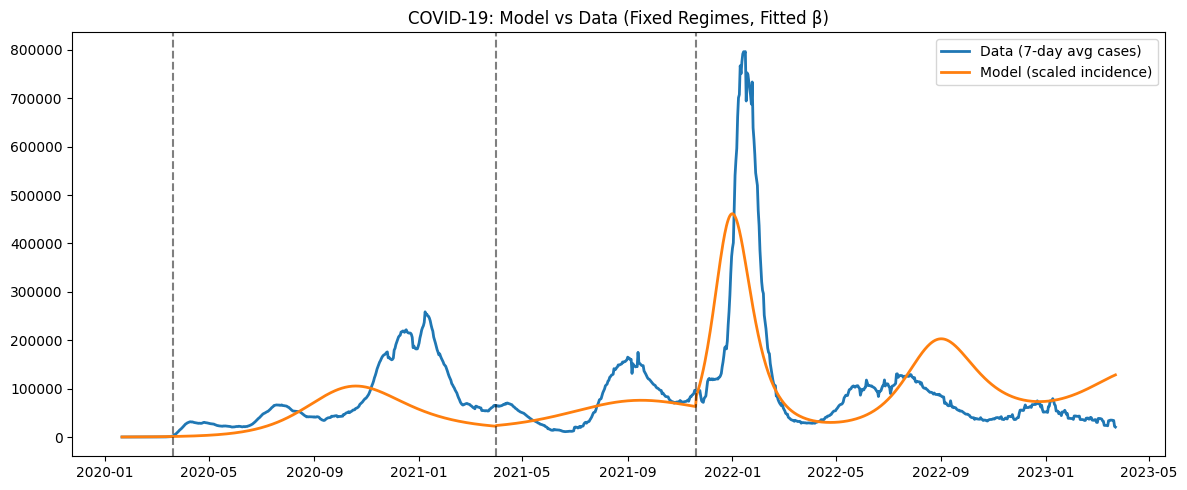

In [49]:
main()